**Implementing Matrix Factorization**

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)

Image Reconstruction- Here, ground truth pixel values are missing for particular regions within the image- you don't have access to them.

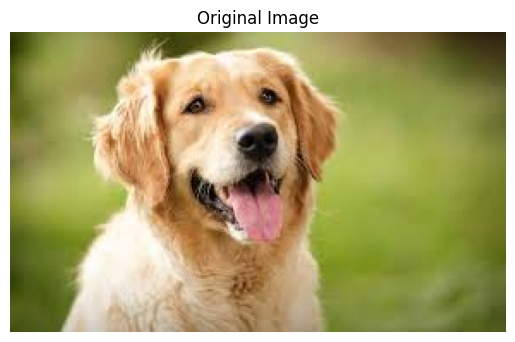

In [ ]:
img = torchvision.io.read_image("dog.jpeg").float() / 255.0

C, H, W = img.shape
img = img.to(device)

plt.imshow(img.permute(1,2,0).cpu()) # Matplotlib cannot use gpu tensors and the image format should be (H,W,3)
plt.title("Original Image")
plt.axis("off")
plt.show()


a rectangular block of 30X30 is assumed missing from the image.

In [ ]:
X = img.permute(1,0,2).reshape(H, C * W) # converting a 3d image to a 2d matrix (H x 3W)
mask_block = torch.ones_like(X) # creates same matrix size as X with all elements 1

#Creating a block
x0 = H // 2 - 15
y0 = (C * W) // 2 - 45

mask_block[x0:x0+30, y0:y0+90] = 0 # Assigning the block pixels as 0
X_block = X * mask_block # applying to the real image where the box will be now empty with missing pixels

a random subset of 900 (30X30) pixels is missing from the image.

In [ ]:
mask_random = torch.ones_like(X) #same like the above one

idx = torch.randperm(X.numel(), device=device)[:900] # numel gives total elements (H*3W), random permutations of indexes(900 because 30x30 pixels)
mask_random.view(-1)[idx] = 0 # flattening 2d to 1d array and assigning the idx elements to zero

X_random = X * mask_random # random pixels will be missed now


Choose rank r yourself. Perform Gradient Descent till convergence, plot the selected regions, original and reconstructed images

In [ ]:
def matrix_factorization_gd(X, mask, rank, lr=0.01, epochs=800):
    H, W = X.shape
    # Generates U, V as random matrices. further the elements will change upon gradient descent updation
    U = torch.randn(H, rank, device=device, requires_grad=True) # U captures row patterns
    V = torch.randn(rank, W, device=device, requires_grad=True) # V captures column patterns

    optimizer = torch.optim.Adam([U, V], lr=lr)

    for it in range(epochs):
        X_hat = U @ V

        lambda_reg = 1e-4  # small regularization

        loss = torch.norm((X_hat - X)[mask.bool()]) + lambda_reg * (torch.norm(U)**2 + torch.norm(V)**2) # mask.bool() ignores those the values which are missing only computes loss for the existing ones


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if it % 200 == 0:
            print(f"Iter {it}, Loss = {loss.item():.4f}")

    Xrec = U @ V
    return Xrec.detach() # .detach() stops gradient tracking


In [ ]:
rank = 30

Xrec_block  = matrix_factorization_gd(X_block,  mask_block,  rank)
Xrec_random = matrix_factorization_gd(X_random, mask_random, rank)

Iter 0, Loss = 2124.8091
Iter 200, Loss = 39.1573
Iter 400, Loss = 25.2200
Iter 600, Loss = 21.0676
Iter 0, Loss = 2143.7183
Iter 200, Loss = 43.0397
Iter 400, Loss = 25.3043
Iter 600, Loss = 21.1735


In [ ]:
def matrix_to_image(Xrec):
    img_rec = Xrec.reshape(H, C, W).permute(1,0,2)
    return torch.clamp(img_rec, 0, 1)

img_block_rec  = matrix_to_image(Xrec_block)
img_random_rec = matrix_to_image(Xrec_random)


Compute the following metrics:

RMSE on predicted v/s ground truth high resolution image and
Peak SNR

In [ ]:
def rmse_psnr(original, reconstructed):
    mse = torch.mean((original - reconstructed)**2)
    rmse = torch.sqrt(mse).item()
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse)).item()
    return rmse, psnr

rmse_b, psnr_b = rmse_psnr(img, img_block_rec)
rmse_r, psnr_r = rmse_psnr(img, img_random_rec)

print(f"Block Missing  → RMSE = {rmse_b:.4f}, PSNR = {psnr_b:.2f} dB")
print(f"Random Missing → RMSE = {rmse_r:.4f}, PSNR = {psnr_r:.2f} dB")


Block Missing  → RMSE = 0.0502, PSNR = 25.98 dB
Random Missing → RMSE = 0.0454, PSNR = 26.86 dB


Final Comparison

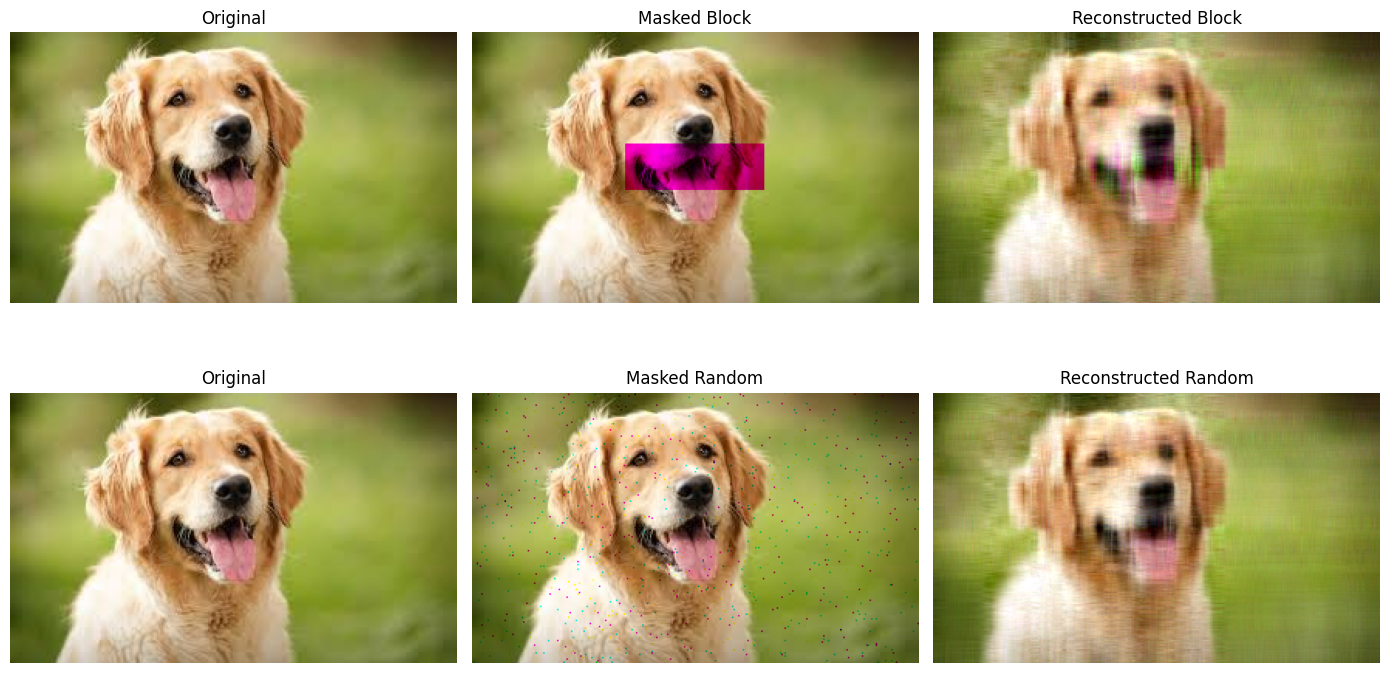

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(14,8))

axs[0,0].imshow(img.permute(1,2,0).cpu())
axs[0,0].set_title("Original")

axs[0,1].imshow((X_block.reshape(H,C,W).permute(1,0,2)).permute(1,2,0).cpu())
axs[0,1].set_title("Masked Block")

axs[0,2].imshow(img_block_rec.permute(1,2,0).cpu())
axs[0,2].set_title("Reconstructed Block")

axs[1,0].imshow(img.permute(1,2,0).cpu())
axs[1,0].set_title("Original")

axs[1,1].imshow((X_random.reshape(H,C,W).permute(1,0,2)).permute(1,2,0).cpu())
axs[1,1].set_title("Masked Random")

axs[1,2].imshow(img_random_rec.permute(1,2,0).cpu())
axs[1,2].set_title("Reconstructed Random")

for ax in axs.flatten():
    ax.axis("off")

plt.tight_layout()
plt.show()


use alternating least squares instead of gradient descent to repeat Part 1, 2 of Image reconstruction problem using your written function.

In [ ]:
def matrix_factorization_als(X, mask, rank=30, iters=20):
    """
    X    : (H, W) masked matrix
    mask : (H, W) binary mask (1 = known, 0 = missing)
    """

    H, W = X.shape
    device = X.device

    # Initialize factors
    U = torch.randn(H, rank, device=device)
    V = torch.randn(rank, W, device=device)

    for it in range(iters):
        # Update U
        for i in range(H):
            idx = mask[i] == 1 # which pixels are known in row i
            if idx.sum() == 0: # if all pixels in that row are missing then skip
                continue

            V_i = V[:, idx].T # extract columns of V
            x_i = X[i, idx]

            # Least squares: V_i @ u_i = x_i
            U[i] = torch.linalg.lstsq(V_i, x_i).solution

        # Update V
        for j in range(W):
            idx = mask[:, j] == 1
            if idx.sum() == 0:
                continue

            U_j = U[idx]
            x_j = X[idx, j]

            V[:, j] = torch.linalg.lstsq(U_j, x_j).solution

        if it % 5 == 0:
            X_hat = U @ V
            loss = torch.norm((X_hat - X)[mask == 1])
            print(f"ALS Iter {it}, Loss = {loss.item():.4f}")

    return (U @ V).detach()


In [ ]:
Xrec_block_als = matrix_factorization_als(
    X_block, mask_block, rank=30, iters=20
)
Xrec_random_als = matrix_factorization_als(
    X_random, mask_random, rank=30, iters=20
)

img_block_rec_als  = matrix_to_image(Xrec_block_als)
img_random_rec_als = matrix_to_image(Xrec_random_als)


ALS Iter 0, Loss = 13.5228
ALS Iter 5, Loss = 7.4991
ALS Iter 10, Loss = 7.4378
ALS Iter 15, Loss = 7.4155
ALS Iter 0, Loss = 19.5662
ALS Iter 5, Loss = 7.8190
ALS Iter 10, Loss = 7.7812
ALS Iter 15, Loss = 7.7651


In [ ]:
rmse_b_als, psnr_b_als = rmse_psnr(img, img_block_rec_als)
rmse_r_als, psnr_r_als = rmse_psnr(img, img_random_rec_als)

print(f"ALS Block Missing  → RMSE = {rmse_b_als:.4f}, PSNR = {psnr_b_als:.2f} dB")
print(f"ALS Random Missing → RMSE = {rmse_r_als:.4f}, PSNR = {psnr_r_als:.2f} dB")


ALS Block Missing  → RMSE = 0.0271, PSNR = 31.34 dB
ALS Random Missing → RMSE = 0.0200, PSNR = 33.99 dB


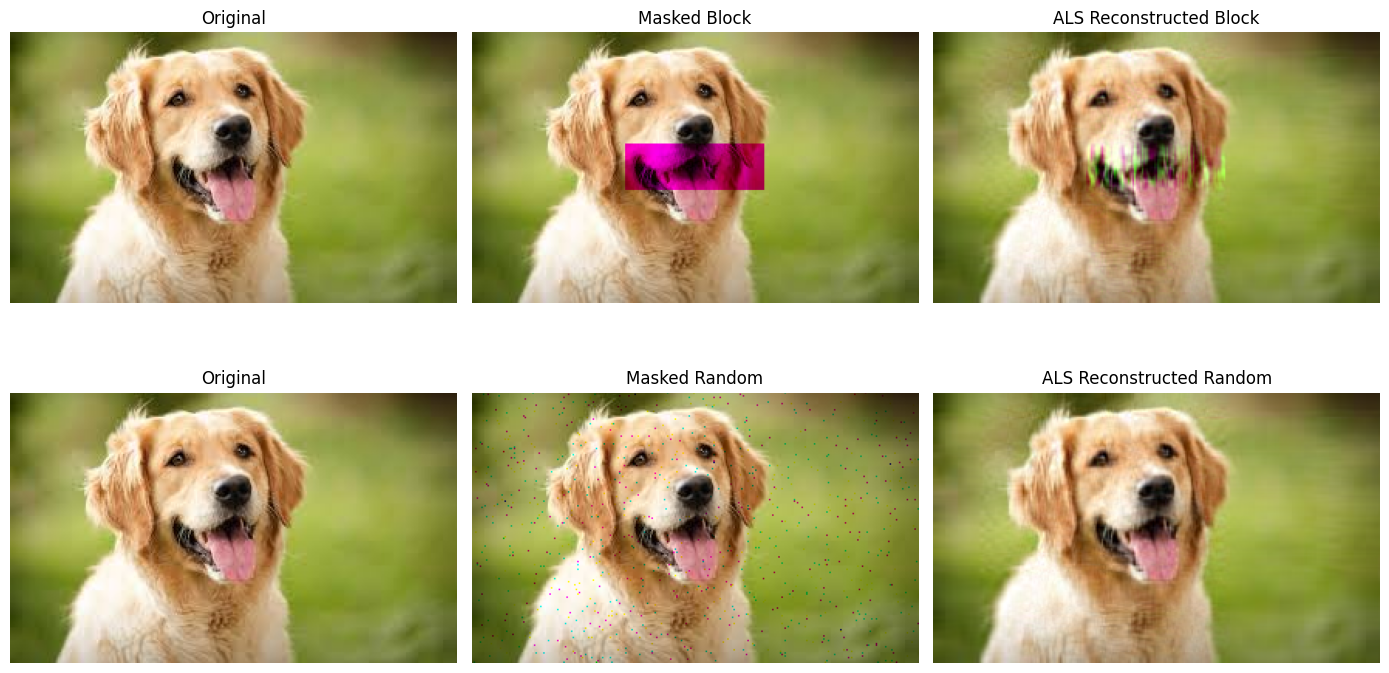

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))

# ---------- Block missing ----------
axs[0,0].imshow(img.permute(1,2,0).cpu())
axs[0,0].set_title("Original")

axs[0,1].imshow(matrix_to_image(X_block).permute(1,2,0).cpu())
axs[0,1].set_title("Masked Block")

axs[0,2].imshow(img_block_rec_als.permute(1,2,0).cpu())
axs[0,2].set_title("ALS Reconstructed Block")

# ---------- Random missing ----------
axs[1,0].imshow(img.permute(1,2,0).cpu())
axs[1,0].set_title("Original")

axs[1,1].imshow(matrix_to_image(X_random).permute(1,2,0).cpu())
axs[1,1].set_title("Masked Random")

axs[1,2].imshow(img_random_rec_als.permute(1,2,0).cpu())
axs[1,2].set_title("ALS Reconstructed Random")

for ax in axs.flatten():
    ax.axis("off")

plt.tight_layout()
plt.show()


Data Compression- Here, ground truth pixel values are not missing- you have access to them. You want to explore the use of matrix factorisation in order to store them more efficiently.

In [ ]:
def matrix_factorization_gd_full(X, rank, lr=0.01, epochs=1500):
    """
    X : (N, M) full matrix (no missing values)
    """
    N, M = X.shape

    U = torch.randn(N, rank, device=device, requires_grad=True)
    V = torch.randn(rank, M, device=device, requires_grad=True)

    optimizer = torch.optim.Adam([U, V], lr=lr)

    for it in range(epochs):
        X_hat = U @ V
        loss = torch.norm(X_hat - X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if it % 500 == 0:
            print(f"Iter {it}, Loss = {loss.item():.4f}")

    return (U @ V).detach()


 Consider an image patch of size (NxN) where N=50. We are trying to compress this patch (matrix) into two matrices, by using low-rank matrix factorization

Vary the low-rank value as r = [5, 10, 25, 50] for each of the cases. Use Gradient Descent and plot the reconstructed patches over the original image

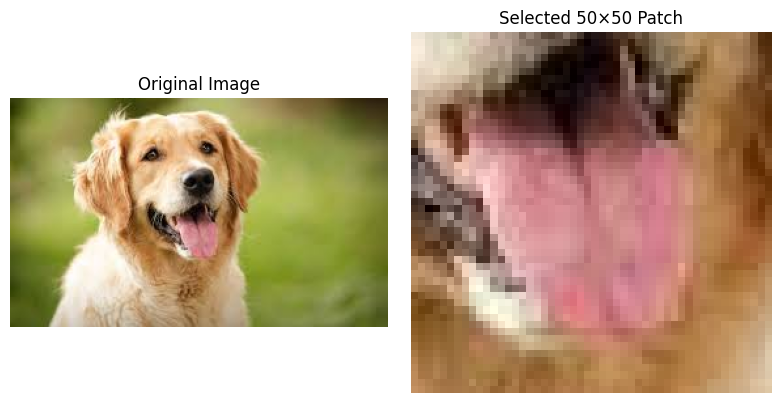


Rank = 5
Iter 0, Loss = 207.2668
Iter 500, Loss = 7.8542
Iter 1000, Loss = 6.7971

Rank = 10
Iter 0, Loss = 279.7256
Iter 500, Loss = 6.4038
Iter 1000, Loss = 4.6670

Rank = 25
Iter 0, Loss = 426.4812
Iter 500, Loss = 3.6889
Iter 1000, Loss = 2.7223

Rank = 50
Iter 0, Loss = 616.9147
Iter 500, Loss = 1.9807
Iter 1000, Loss = 1.5725


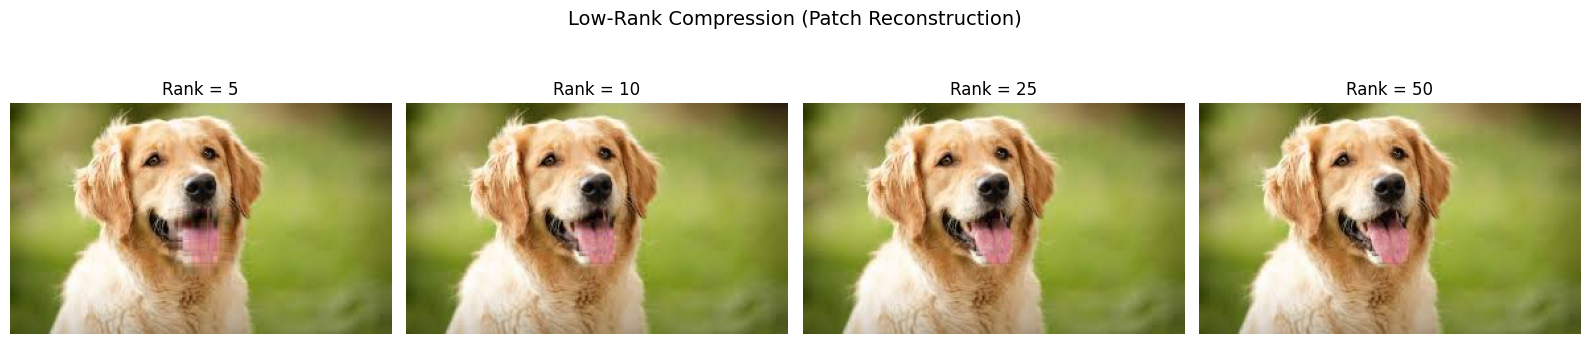

In [ ]:
# choose patch location (change for different cases)
top, left = 80, 120
size = 50
# extract patch
patch = img[:, top:top+size, left:left+size]
C, H, W = patch.shape

# patch → matrix
X_patch = patch.permute(1,0,2).reshape(H, C*W)

# show original image + patch
fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].imshow(img.permute(1,2,0).cpu())
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(patch.permute(1,2,0).cpu())
axs[1].set_title("Selected 50×50 Patch")
axs[1].axis("off")

plt.tight_layout()
plt.show()

# ranks to test
ranks = [5, 10, 25, 50]

fig, axs = plt.subplots(1, len(ranks), figsize=(16,4))

for i, r in enumerate(ranks):
    print(f"\nRank = {r}")

    Xrec = matrix_factorization_gd_full(X_patch, rank=r)
    rec_patch = Xrec.reshape(50, 3, 50).permute(1,0,2)

    img_rec = img.clone()
    img_rec[:, top:top+50, left:left+50] = rec_patch
    img_rec = torch.clamp(img_rec, 0, 1)

    axs[i].imshow(img_rec.permute(1,2,0).cpu())
    axs[i].set_title(f"Rank = {r}")
    axs[i].axis("off")

plt.suptitle("Low-Rank Compression (Patch Reconstruction)", fontsize=14)
plt.tight_layout()
plt.show()
